In [1]:
import numpy as np
from queue import Queue
from collections import defaultdict
import networkx as nx
from networkx import DiGraph

In [2]:
def check_connected_to_input(node, graph, attribute_map):
    connections = [x for x in graph.neighbors(node)]
    for neighbor in connections:
        if attribute_map[neighbor]['TYPE'] == 'INPUT':
            return True
    return False


In [3]:
# Algorithm 2
def disallowed_nodes(node, level, depth, nonleaf, attribute_map, graph) -> set:
    restricted_types = set()
    connected_to_input = check_connected_to_input(node, graph, attribute_map)
    
    if connected_to_input or not nonleaf:
        restricted_types.add('INPUT')
    
    if (level + 2 == depth) or attribute_map[node]['TYPE'] in {'SUM', 'CONCAT'}:
        restricted_types.add('BINARY')
        
    return restricted_types
    

In [12]:
def get_new_node():
    return defaultdict(
        TYPE=None,
        ARITY=None
    )

In [24]:
# Algorithm 4
def random_node(restricted_nodes:set) -> dict:
    feature_map_choices = (32, 64, 128, 256, 512)
    all_types = set(('BINARY', 'CONV', 'POOL', 'INPUT', 'REFERENCE'))
    valid_types = all_types.difference(restricted_nodes)
    random_node_type = np.random.choice(tuple(valid_types), size=1).item()
    new_node = get_new_node()
    
    if random_node_type == 'BINARY':
        q = np.random.uniform()
        if q < 0.5:
            new_node['TYPE'] = 'SUM'
        else:
            new_node['TYPE'] = 'CONCAT'  
        
        new_node['ARITY'] = 2
                
    elif random_node_type == 'CONV':
        new_node['TYPE'] = 'CONV'
        new_node['FEATURE_MAPS'] = np.random.choice(feature_map_choices)
        new_node['ARITY'] = 1
        
    elif random_node_type == 'POOL':
        q = np.random.uniform()
        if q < 0.5:
            new_node['TYPE'] = 'MAX'
        else:
            new_node['TYPE'] = 'AVERAGE'
            
        new_node['ARITY'] = 1
            
    elif random_node_type == 'INPUT':
        new_node['TYPE'] = 'INPUT'
        new_node['ARITY'] = 0
        
    else:
        new_node = None
    return new_node

In [29]:
def get_random_node(graph):
    num_nodes = graph.number_of_nodes()
    if num_nodes == 1:
        return 1
    else:
        return np.random.choice(range(1, num_nodes))
    

In [30]:
# Algorithm 3
def add_missing_edges(S, graph, attribute_map, max_iter=100):
    for node in S:
        k = 0
        t = None
        valid = False

        while k < max_iter:
            t = get_random_node(graph)
            b_1 = nx.has_path(graph, t, node)
            b_2 = t in nx.neighbors(graph, node)
            if attribute_map[t]['TYPE'] != 'INPUT' and not b_1 and not b_2:
                valid = True
                break
            k += 1

        if valid:
            graph.add_edge(node, t)
        else:
            new_node = graph.number_of_nodes() + 1
            graph.add_node(new_node)
            graph.add_edge(node, new_node)
            attribute_map[new_node]['TYPE'] = 'INPUT'

    return graph, attribute_map
            

In [31]:
# Algorithm 1
def initialise_archs(max_depth=100):
    init_q = Queue()
    depth = np.random.randint(0, max_depth)
    level = 0
    nonleaf = False

    graph = DiGraph()
    graph.add_node(
        0,
    )

    init_q.put((0, 0))  # (node number, level). Root node = 0
    node_counter = 1

    attribute_map = defaultdict(dict)
    attribute_map[0] = dict(
        TYPE='OUTPUT',
        FEATURE_MAPS=None,
        ARITY=1
    )

    S = set()
    while not init_q.empty():
        node, l = init_q.get()
        arity = attribute_map[node]['ARITY']

        if l != level:
            nonleaf = False
            level = l
        i = 0
        while i < arity:
            if l + 1 == depth:
                attribute_map[node_counter] = dict(
                    TYPE='INPUT',
                    ARITY=0
                )
                graph.add_node(
                    node_counter,
                )
                graph.add_edge(node, node_counter)
                node_counter += 1
            else:
                restricted_node_types = disallowed_nodes(node, l, depth, nonleaf, attribute_map, graph)
                new_node = random_node(restricted_node_types)
                if new_node is None:
                    S.add(node)
                else:
                    attribute_map[node_counter] = new_node
                    graph.add_node(node_counter)
                    graph.add_edge(node, node_counter)

                    if new_node['TYPE'] != 'INPUT':
                        init_q.put((node_counter, l + 1))
                        nonleaf = True

            i += 1

    graph, attribute_map = add_missing_edges(S, graph, attribute_map, max_iter=100)
    return graph, attribute_map

In [36]:
initialise_archs(max_depth=10)

(<networkx.classes.digraph.DiGraph at 0x2a353565070>,
 defaultdict(dict,
             {0: {'TYPE': 'OUTPUT', 'FEATURE_MAPS': None, 'ARITY': 1},
              1: defaultdict(None, {'TYPE': 'AVERAGE', 'ARITY': 1}),
              3: {'TYPE': 'INPUT'}}))

In [47]:
test_graph = DiGraph()

In [92]:
# test_graph.add_nodes_from([node, 2, 3, 4, 5])
att = dict(
    TYPE='INPUT',
    FEATURE_MAPS=None,
    ARITY=0
)
test_graph.add_node(
    1,
    object=None,
    **att
)

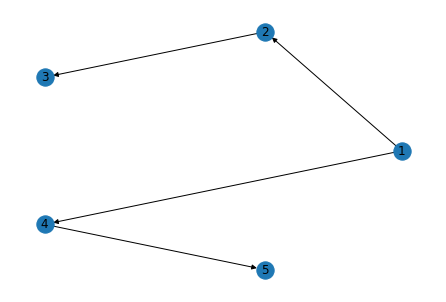

In [93]:
nx.draw_shell(test_graph, with_labels=True)

In [117]:
np.random.choice(range(1, test_graph.number_of_nodes()))

4

In [114]:
np.random.choice(test_graph.nodes)

3

In [ ]:
[k for k,v in nx.get_node_attributes(test_graph, 'TYPE').items() if v=='INPUT']

In [ ]:
[x for x in test_graph.neighbors(1)]

In [ ]:
dir(test_graph)

In [ ]:
[x for x in nx.neighbors(test_graph, 4)]

In [ ]:
5 in nx.all_neighbors(test_graph, 1)

[1]

In [107]:
[x for x in test_graph.neighbors(1)]

[4, 2]

In [119]:
dir(test_graph)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adj',
 '_node',
 '_pred',
 '_succ',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'copy',
 'degree',
 'edge_attr_dict_factory',
 'edge_subgraph',
 'edges',
 'get_edge_data',
 'graph',
 'graph_attr_dict_factory',
 'has_edge',
 'has_node',
 'has_predecessor',
 'has_successor',
 'in_degree',
 'in_edges',
 'is_directed',
 'is_multigraph',
 'name',
 'nbunch_iter',
 'neighbors',
 'node_attr_dict_factory',
 'node_dict_factory',
 'n

In [126]:
[x for x in nx.neighbors(test_graph, 4)]

[5]

In [124]:
5 in nx.all_neighbors(test_graph, 1)

False